# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [5]:
# 1.4)
import google.colab
from google.colab import files

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [6]:
# 2.1)
# Define a transform to normalize the data
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
# transform = transforms.Compose([transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))
transform = transforms.Compose([
    transforms.ToTensor(),                # Reorganiza Formato (Canales, Alto, Ancho), y Normaliza a [0, 1]. En este caso Formato (1, 28, 28). 0–255 → 0–1
    transforms.Normalize((0.5,), (0.5,))  # Centra los datos en 0, y los reescala a [-1, 1].
])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 183kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.42MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.0MB/s]


In [7]:
#2.2)
labels_names = {
    0: "T-Shirt", #remera
    1: "Trouser", #pantalon
    2:	"Pullover", #buzo
    3:	"Dress", #vestido
    4:	"Coat", #abrigo
    5:	"Sandal", #sandalia
    6:	"Shirt", #camisa
    7:	"Sneaker", #zapatilla
    8:	"Bag", #bolso
    9:	"Ankle Boot" #bota
}

In [8]:
np.random.seed(123)
torch.manual_seed(123)

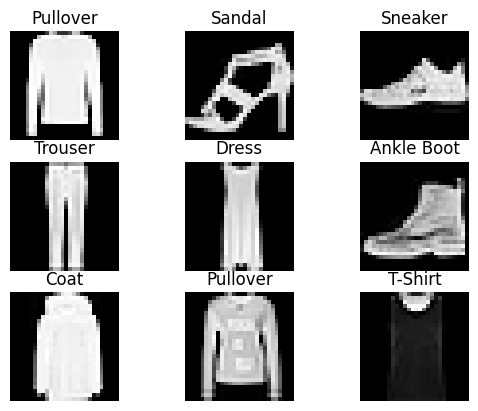

In [9]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [10]:
# 3.1)
# Creamos una subclase de la clase Dataset que nos sirva para generar lotes de ejemplos que puedan usarse para entrenar un autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset

    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)

    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image #torch.flatten(image) # retornamos la imagen como salida
        return input,output

In [11]:
# 3.2)
# Convertimos FashionMNIST Dataset a CustomDataset
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

## Parte 1) Autoencoder Convolucional Profundo

**1)** Defina y cree una red neuronal *autoencoder convolucional* multicapas.

<!-- constituida por las siguientes capas:


1. Capa convolucional 2D (encoder) compuesta por:

  * Una capa `Conv2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) que mapea una entrada con $1$ canal y dimensiones $(28,28)$ a una salida con $16$ canales y dimensiones $(26,26)$.
    Utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
  * Una capa `ReLU`.
  * Una capa `MaxPool2d` con un kernel de dimensiones $(2,2)$, de modo que la salida resultante tenga dimensiones $(16,13,13)$.
  * Una capa `Dropout` con probabilidad $p$.

2. Capa lineal (cuello de botella o “bottleneck”) compuesta por:

  * Una capa `Flatten` que transforma una entrada de dimensiones $(16,13,13)$ en un vector de dimensión $16\times 13\times 13 = 2704$.
  * Una capa `Linear` que mapea el vector de dimensión $2704$ a un vector de dimensión $n$ (donde $n$ es un número mucho menor, por ejemplo $n=128$, representando la *codificación comprimida* o *latente*).
  * Una capa `ReLU`.
  * Una capa `Linear` que mapea de nuevo el vector de dimensión $n$ al espacio original de dimensión $2704$.
  * Una capa `ReLU`.

3. Capa convolucional 2D transpuesta (decoder) compuesta por:

  * Una capa `Unflatten` que mapea el vector de dimensión $2704$ a una representación de $16$ canales con dimensiones $(13,13)$.
  * Una capa `ConvTranspose2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Utilice un kernel de dimensiones $(6,6)$, un stride de $(2,2)$, y un padding de $(1,1)$.
  * Una capa `Sigmoid`, para asegurar que las salidas se encuentren en el rango $[0,1]$ (asumiendo que las imágenes originales también fueron normalizadas en dicho rango). -->

**2)** Grafique, a modo de comparación, algunas imágenes de entrada y sus correspondientes reconstrucciones obtenidas con el modelo **sin entrenar** y con una probabilidad de *dropout* $p=0.2$.

In [12]:
# 4.1) CREAR
class AutoencoderConv(nn.Module):
    def __init__(self, n=64, p=0.2):
        super().__init__()

        # -------- ENCODER --------
        self.encoder = nn.Sequential(
            # (1,28,28)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # -> (32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),                              # -> (32,14,14)
            nn.Dropout(p),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> (64,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2),                              # -> (64,7,7)
            nn.Dropout(p),

            nn.Conv2d(64, n, kernel_size=3, padding=1),   # bottleneck
            nn.ReLU()
        )

        # -------- DECODER --------
        self.decoder = nn.Sequential(
            # (latent,7,7)
            nn.ConvTranspose2d(n, 64, kernel_size=2, stride=2),  # -> (64,14,14)
            nn.ReLU(),
            nn.Dropout(p),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), # -> (32,28,28)
            nn.ReLU(),
            nn.Dropout(p),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),          # -> (1,28,28)
            nn.Tanh()       # porque Normalize → [-1,1] y más moderno
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x


In [13]:
# 4.2
# INSTANCIAR Modelo
p = 0.2
n = 64
model = AutoencoderConv(n=n, p=p)

In [14]:
# Create a dummy input tensor
image = torch.randn(1, 1, 28, 28) # batch size 1, channel 1, size 28x28
output = model(image)
print(f"Input size: {image.size()}")
print(f"Output size: {output.size()}")

Input size: torch.Size([1, 1, 28, 28])
Output size: torch.Size([1, 1, 28, 28])


In [15]:
def batch(x):
    return x.unsqueeze(0)   # (1,28,28) -> (1,1,28,28)

def unbatch(x):
    return x.squeeze().detach().cpu().numpy() # elimina TODAS las dims de 1

In [16]:
model.eval()

image, _ = train_set[0]

batched_image = batch(image)
print("batched_image.size()=", batched_image.size())

with torch.no_grad():
    pred_batched_image = model(batched_image)

print("pred_batched_image.size()=", pred_batched_image.size())

pred_image = unbatch(pred_batched_image)
print("pred_image.shape=", pred_image.shape)

batched_image.size()= torch.Size([1, 1, 28, 28])
pred_batched_image.size()= torch.Size([1, 1, 28, 28])
pred_image.shape= (28, 28)


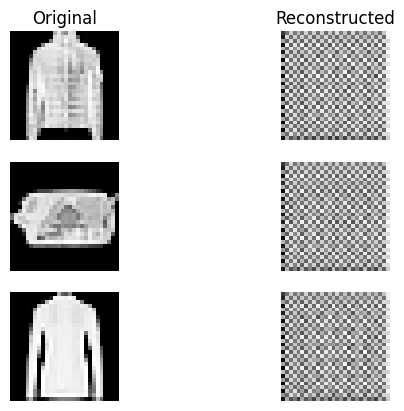

In [17]:
model.eval()

figure = plt.figure()
rows, cols = 3, 2
i = 0

for row in range(1, rows + 1):
    j = torch.randint(len(train_set), size=(1,)).item()

    image, _ = train_set[j]

    # ORIGINAL
    i += 1
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title("Original")
    plt.axis("off")
    plt.imshow(unbatch(image), cmap="Greys_r")

    # RECONSTRUCCIÓN
    i += 1
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title("Reconstructed")
    plt.axis("off")

    with torch.no_grad():
        image_pred = model(batch(image))

    plt.imshow(unbatch(image_pred), cmap="Greys_r")

plt.show()

### Parte 1.b) Autoencoder Convolucional Profundo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [18]:
# En un autoencoder el objetivo no es clasificar sino reconstruir la entrada.
# Por lo tanto métricas de clasificación como accuracy, precision o recall
# no son relevantes. La calidad del modelo se evalúa mediante una función
# de reconstrucción, típicamente MSE o Binary Cross Entropy según el caso.

In [19]:
# 5.1)
# Definir Función de Entrenamiento.
def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
  # Activar la maquinaria de entrenamiento del modelo
  model.train()

  # Definir constantes
  num_samples = len(dataloader.dataset)
  num_batches = len(dataloader)

  sum_loss = 0
  sum_samples = 0

  # Mover el modelo a la GPU si es que está disponible
  model = model.to(device)

  # Iterar sobre los lotes (batchs)
  for batch, (X, y) in enumerate(dataloader):
    # Copiar las entradas y las salidas al dispositivo de trabajo si es que está disponible
    X = X.to(device) # la imagen
    y = y.to(device) # la misma imagen.

    batch_size = len(X)
    sum_samples += batch_size

    # Calcular la predicción del modelo y la correspondiente función de pérdida
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagar usando el optimizador
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calcular la pérdida promedio del batch y agregar a la suma correspondiente
    sum_loss += (loss.item() * batch_size)
    # Reportar el progreso
    if batch % max(1, num_batches//10) == 0 and verbose:
      avrg_loss = sum_loss / sum_samples
      print(f"@train_loop batch={batch:>5d} avrg_loss ={avrg_loss:>7f} processed-samples={100*sum_samples/num_samples:>5f}%")

  avrg_loss = sum_loss/sum_samples
  return avrg_loss

In [20]:
# 5.2)
# Definir Función de Validación
def eval_loop(dataloader, model, loss_fn, ds_train_valid="eval"):
  # Desactivar la maquinaria de entrenamiento del modelo
  model.eval() #activar la maquinaria de validación del modelo

  sum_loss = 0
  sum_samples = 0

  # Mover el modelo a GPU si está disponible
  model = model.to(device)

  # Para testear, desactivar el cálculo de gradientes
  with torch.no_grad():
    # iterar sobre los lotes (batches)
    for X, y in dataloader:
      # Copiar las entradas y salidas al dispositivo de trabajo si es que está disponible
      X = X.to(device)
      y=y.to(device)

      batch_size = len(X)
      sum_samples += batch_size

      # calcular la predicción del modelo y pérdida
      pred = model(X)
      loss = loss_fn(pred, y)

      # Calcular la pérdida promedio del batch y agregarlo a la suma correspondiente
      sum_loss += (loss.item() * batch_size)

  # Calcular la pérdida total y la fracción de clasificaciones correctas
  avrg_loss = sum_loss/sum_samples
  print(f"@eval_loop [{ds_train_valid}] avg_loss = {avrg_loss:>8f} ")
  return avrg_loss

In [21]:
#5.3)
# Crear los DataLoaders : Inicializar el train_loader y valid_loader
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

print(f"num_train_batches = {len(train_loader)}")
print(f"num_valid_batches = {len(valid_loader)}")

num_train_batches = 600
num_valid_batches = 100


In [22]:
# 5.4)
# Función de pérdida para reconstrucción
loss_fn = nn.MSELoss() # Para Autoencoder se usa la MSE!

In [23]:
# 5.5)
# Crear el Modelo
p = 0.2
n = 64
model = AutoencoderConv(n=n, p=p)

In [24]:
# 5.6)
# Crear un optimizador que utilice el método de Stochastic Gradient Descent o ADAM
learning_rate = 1e-3 # = 10^(-3) = 0.001
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #cambiar luego por adam y probar tambien!
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    eps=1e-8,
    weight_decay=0,
    amsgrad=False
)

In [25]:
# 5.7)
# Determinar en qué dispositivo vamos a trabajar, una GPU o CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# pasar el modelo al dispositivo
model = model.to(device)

In [26]:
# 5.8 y 5.9)
num_epochs = 10

list_train_avg_loss_inc = []
list_train_avg_loss = []
list_valid_avg_loss = []

for epoch in range(num_epochs):

    print("\n--------------------------------------------------")
    print(f"Epoch {epoch+1}\n----------")

    train_avg_loss_incorrecta = train_loop(train_loader, model, loss_fn, optimizer)
    train_avg_loss = eval_loop(train_loader, model, loss_fn, ds_train_valid="train")
    valid_avg_loss = eval_loop(valid_loader, model, loss_fn, ds_train_valid="valid")
    list_train_avg_loss_inc.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)

print("\nDone!")


--------------------------------------------------
Epoch 1
----------
@train_loop batch=    0 avrg_loss =0.634621 processed-samples=0.166667%
@train_loop batch=   60 avrg_loss =0.257109 processed-samples=10.166667%
@train_loop batch=  120 avrg_loss =0.173919 processed-samples=20.166667%
@train_loop batch=  180 avrg_loss =0.138027 processed-samples=30.166667%
@train_loop batch=  240 avrg_loss =0.117554 processed-samples=40.166667%
@train_loop batch=  300 avrg_loss =0.104148 processed-samples=50.166667%
@train_loop batch=  360 avrg_loss =0.094522 processed-samples=60.166667%
@train_loop batch=  420 avrg_loss =0.087226 processed-samples=70.166667%
@train_loop batch=  480 avrg_loss =0.081433 processed-samples=80.166667%
@train_loop batch=  540 avrg_loss =0.076743 processed-samples=90.166667%
@eval_loop [train] avg_loss = 0.027525 
@eval_loop [valid] avg_loss = 0.027731 

--------------------------------------------------
Epoch 2
----------
@train_loop batch=    0 avrg_loss =0.037019 proce

In [27]:
# SAVE
print(model)

torch.save({
    "model_state_dict": model.state_dict(),
    "n": n,
    "p": p
}, f"autoencoder_conv_{num_epochs}.pth")


AutoencoderConv(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)


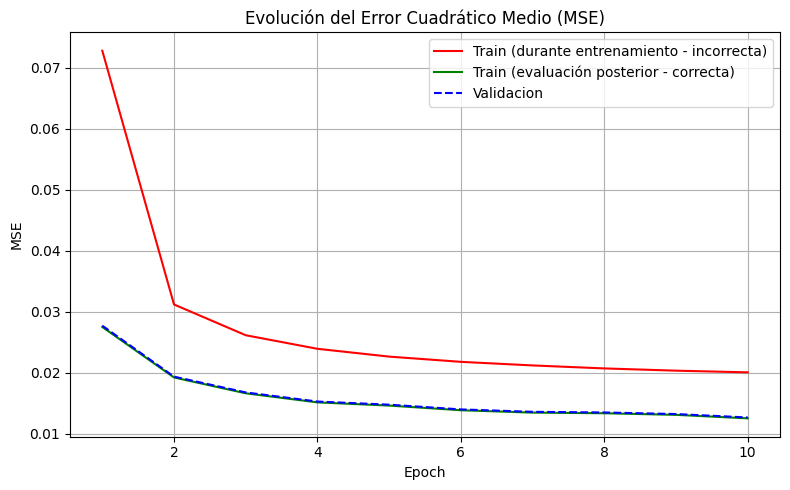

In [28]:
# 5.10) Graficar evolución del ECM
# En autoencoders no se usa accuracy porque no hay clasificación.
# La métrica relevante es el error de reconstrucción (MSE).

plt.figure(figsize=(8,5))

plt.title("Evolución del Error Cuadrático Medio (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE")

epochs = range(1, len(list_train_avg_loss)+1)

plt.plot(epochs, list_train_avg_loss_inc,
         label="Train (durante entrenamiento - incorrecta)",
         linestyle='-', color='red')

plt.plot(epochs, list_train_avg_loss,
         label="Train (evaluación posterior - correcta)",
         linestyle='-', color='green')

plt.plot(epochs, list_valid_avg_loss,
         label="Validacion",
         linestyle='--', color='blue')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"autoencoder_loss_curves_{num_epochs}.png", dpi=300, bbox_inches="tight")
plt.show()

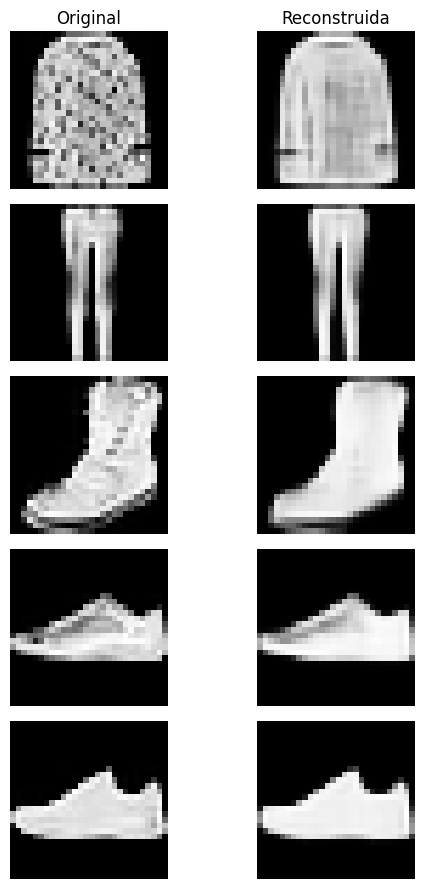

In [29]:
# 11) Comparar imágenes originales vs reconstruidas (modelo entrenado)

model.eval()  # importante: desactiva dropout

figure = plt.figure(figsize=(6, 9))
rows, cols = 5, 2   # 5 ejemplos (original + reconstruida)
i = 0

with torch.no_grad():
    for row in range(rows):

        # elegir imagen aleatoria
        idx = torch.randint(len(valid_set), (1,)).item()
        image, _ = valid_set[idx]

        # reconstrucción
        image_pred = model(batch(image).to(device))
        image_pred = unbatch(image_pred)

        # ---- original ----
        i += 1
        figure.add_subplot(rows, cols, i)
        if row == 0:
            plt.title("Original")
        plt.axis("off")
        plt.imshow(unbatch(image), cmap="Greys_r")

        # ---- reconstruida ----
        i += 1
        figure.add_subplot(rows, cols, i)
        if row == 0:
            plt.title("Reconstruida")
        plt.axis("off")
        plt.imshow(image_pred, cmap="Greys_r")

plt.tight_layout()
plt.show()


## Parte 2) Clasificador Multicapa. Transfer learning (*Encoder congelado*).

**1)** Defina y cree un Clasificador Multicapa reutilizando el Encoder del Autoencoder Convolucional entrenado anteriormente.
<!-- Más precisamente, el clasificador convolucional tiene que tener las siguientes capas:

Primero,el encoder del autoencoder entrenado anteriormente. este mapea una entrada de dimensiones (1,28,28) a una salida de dimension n.

Luego una capa lineal de clasificacion compuesta:
* Una capa Lineal que mapea dimension (n, ) a dimensión (10, ).
* Una capa ReLu.
* Una capa Dropout. -->


**2)** Reimplemente las funciones con los loop de entrenamiento y validacion adaptados para el problema de clasificacion (i.e. incorpóreles el cálculo de la precisión).

**3)** Cree una función de pérdida usando la **Cross Entropy Loss** (CEL).



**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con $n=64$ neuronas en la capa intermedia y dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en 4 listas los valores promedios de la **CEL** y la **Precision**, en funcion de las Epocas, para cada conjunto:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **CEL** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Utilice el Conjunto de Validación para calcular la **Matriz de Confusión**. Grafiquela y comente los resultados.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el valor de **n**, el optimizador **SGD**, el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños, cambiar la Sigmoide por ReLu en la capa de salida..
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?


In [30]:
model

AutoencoderConv(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [32]:
# LOAD Autoencoder
checkpoint = torch.load(f"autoencoder_conv_{num_epochs}.pth", map_location=device)

autoencoder_pretrained = AutoencoderConv(
    n=checkpoint["n"],
    p=checkpoint["p"]
    # n=n,
    # p=p
)

autoencoder_pretrained.load_state_dict(checkpoint["model_state_dict"])

autoencoder_pretrained = autoencoder_pretrained.to(device)
autoencoder_pretrained.eval()

AutoencoderConv(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [33]:
# 6.1)
# Definir Función de Entrenamiento.
def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
  # Activar la maquinaria de entrenamiento del modelo
  model.train()

  num_samples = len(dataloader.dataset)
  num_batches = len(dataloader)

  sum_loss = 0
  sum_correct = 0
  sum_samples = 0

  # iterar sobre los lotes (batches)
  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    batch_size = len(X)
    sum_samples = sum_samples + batch_size

    #calcular la predicción y perdida
    pred = model(X)
    loss = loss_fn(pred, y)

    #backpropagar con el optimizador
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #calcular la pérdida promedio
    sum_loss = sum_loss + (loss.item() * batch_size)
    #calcular el número de predicciones correctas
    sum_correct = sum_correct + ((pred.argmax(1) == y).type(torch.float).sum().item())

    if verbose and batch % max(1, num_batches // 10) == 0:
      avrg_loss = sum_loss/sum_samples
      precision = sum_correct/sum_samples
      print(f"@train_loop batch= {batch:>5d} avrg_loss ={avrg_loss:>7f} sample procesados= {100*sum_samples/num_samples:>5f}%")

  avrg_loss = sum_loss/sum_samples
  precision = sum_correct/sum_samples
  return avrg_loss, precision

In [34]:
# 6.2)
# Definir Función de Validación.
def eval_loop(dataloader, model, loss_fn, ds_train_valid="eval"):
  # Activar la maquinaria de validación del modelo
  model.eval()

  num_samples = len(dataloader.dataset)
  num_batches = len(dataloader)

  sum_loss = 0
  sum_correct = 0
  sum_samples = 0

  #desactivar el cálculo de gradientes
  with torch.no_grad():
    #iterar sobre los lotes (batches)
    for X, y in dataloader:
      X = X.to(device)
      y=y.to(device)

      batch_size = len(X)
      sum_samples = sum_samples + batch_size
      #calcular la predicción y perdida
      pred = model(X)
      loss = loss_fn(pred, y)
      #calcular la pérdida promedio
      sum_loss = sum_loss + (loss.item() * batch_size)
      #calcular el número de predicciones correctas
      sum_correct = sum_correct + ((pred.argmax(1) == y).type(torch.float).sum().item())

  avrg_loss = sum_loss/sum_samples
  precision = sum_correct/sum_samples
  print(f"@eval_loop [{ds_train_valid}] avg_loss = {avrg_loss:>8f} precision = {(100 * precision):>0.1f}%")
  return avrg_loss, precision

In [36]:
# Definir Modelo
class ClasificadorConv(nn.Module):

    def __init__(
        self,
        autoencoder_pretrained: nn.Module,
        num_classes: int = 10,
        hidden_dim: int = 128,
        dropout: float = 0.3
    ):
        super().__init__()



        # -------- ENCODER PREENTRENADO --------
        print("Transfer Learning: usando Encoder pre-entrenado del autoencoder")
        self.encoder = autoencoder_pretrained.encoder
        self.encoder.eval()

        # CONGELAR encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # -------- CALCULAR DIMENSION DE FEATURES --------
        with torch.no_grad():
            device = next(self.encoder.parameters()).device
            dummy = torch.zeros(1, 1, 28, 28, device=device)
            feat = self.encoder(dummy)
            feat_dim = feat.view(1, -1).shape[1]

        # -------- CLASIFICADOR --------
        self.clasificador = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.clasificador(x)
        return x

In [37]:
# 6.4)
# Inicializar el train_loader y valid_loader
# batch_size = 100
train_loader = DataLoader(train_set_orig, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set_orig, batch_size=batch_size, shuffle=False)

In [38]:
# 6.5)
# Función de pérdida para el Clasificador
loss_fn = nn.CrossEntropyLoss()

In [39]:
model_autoencoder = model

In [40]:
# 6.6)
# Crear el Modelo
clasificador_conv = ClasificadorConv(autoencoder_pretrained=autoencoder_pretrained)
model = clasificador_conv.to(device)

Transfer Learning: usando Encoder pre-entrenado del autoencoder


In [41]:
# 6.7)
# Crear un optimizador que utilice el método de Stochastic Gradient Descent o ADAM
learning_rate = 1e-3 #10 ** -3

# Optimizamos solo los parámetros de la capa Clasificadora: model.clasificador.parameters()
optimizer = torch.optim.Adam(
    model.clasificador.parameters(),# Solo entrenamos el Clasificador
    lr=learning_rate
)

In [42]:
# 6.8)
# Determinar en qué dispositivo vamos a trabajar, una GPU o CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)
model = model.to(device)

device = cuda


In [43]:
#6.8) y #6.9)
num_epochs = 50
list_train_avg_loss_inc=[]
list_train_avg_loss=[]
list_valid_avg_loss=[]
list_train_precision_inc=[]
list_train_precision=[]
list_valid_precision=[]

for epoch in range(num_epochs):
  print(f"\n--------------------------------------------------")
  print(f"Epoch {epoch+1}\n----------")
  train_avg_loss_incorrecta, train_precision_incorrecta = train_loop(train_loader, model, loss_fn, optimizer)
  train_avg_loss, train_precision = eval_loop(train_loader, model, loss_fn, ds_train_valid="train")
  valid_avg_loss, valid_precision = eval_loop(valid_loader, model, loss_fn, ds_train_valid="valid")
  list_train_avg_loss_inc.append(train_avg_loss_incorrecta)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
  list_train_precision_inc.append(train_precision_incorrecta)
  list_train_precision.append(train_precision)
  list_valid_precision.append(valid_precision)

print("\nDone!")


--------------------------------------------------
Epoch 1
----------
@train_loop batch=     0 avrg_loss =2.265991 sample procesados= 0.166667%
@train_loop batch=    60 avrg_loss =0.869164 sample procesados= 10.166667%
@train_loop batch=   120 avrg_loss =0.713100 sample procesados= 20.166667%
@train_loop batch=   180 avrg_loss =0.645532 sample procesados= 30.166667%
@train_loop batch=   240 avrg_loss =0.597493 sample procesados= 40.166667%
@train_loop batch=   300 avrg_loss =0.568088 sample procesados= 50.166667%
@train_loop batch=   360 avrg_loss =0.546483 sample procesados= 60.166667%
@train_loop batch=   420 avrg_loss =0.528320 sample procesados= 70.166667%
@train_loop batch=   480 avrg_loss =0.515602 sample procesados= 80.166667%
@train_loop batch=   540 avrg_loss =0.505576 sample procesados= 90.166667%
@eval_loop [train] avg_loss = 0.331303 precision = 88.0%
@eval_loop [valid] avg_loss = 0.358868 precision = 87.1%

--------------------------------------------------
Epoch 2
------

In [44]:
# ants del show plt.savefig("loss_curves.png", dpi=300, bbox_inches="tight")

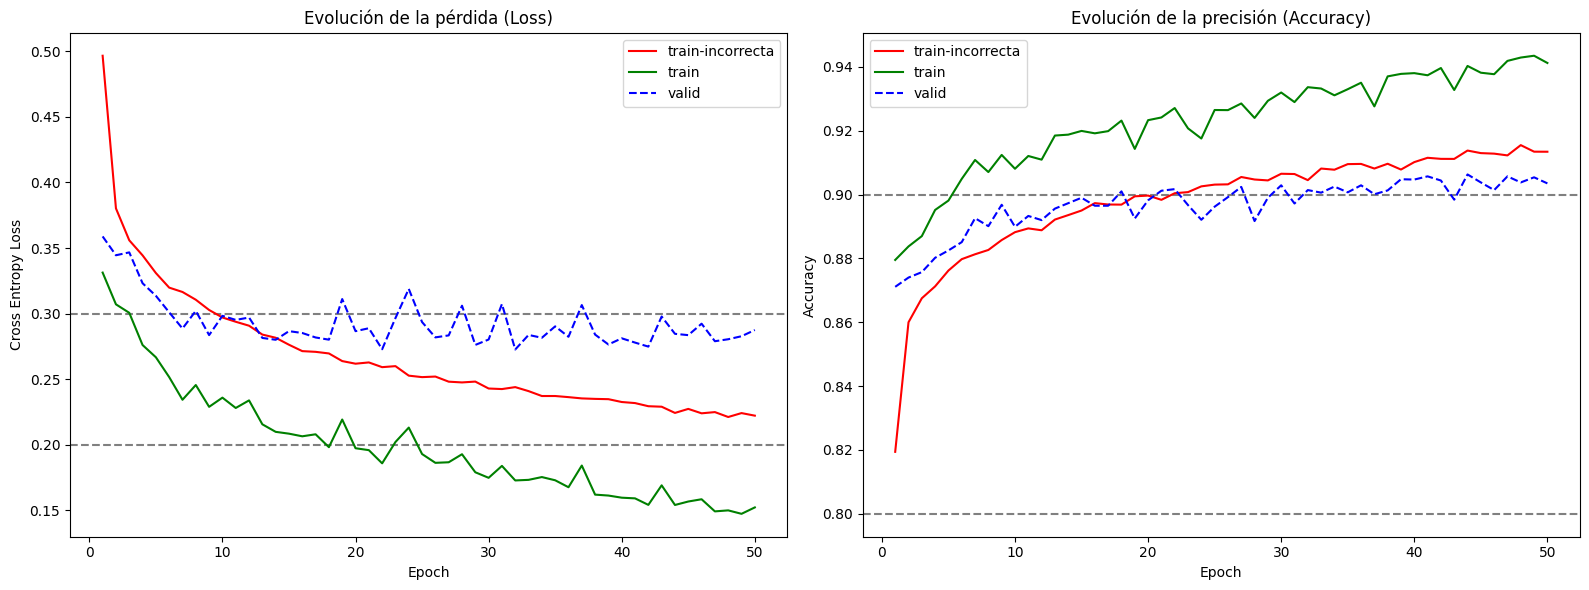

In [45]:
# 5.10) Graficar evolución del ECM
# En autoencoders no se usa accuracy porque no hay clasificación.
# La métrica relevante es el error de reconstrucción (MSE).

#5.10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# ---------------------------
# SUBPLOT 1: LOSS
# ---------------------------
axes[0].set_title("Evolución de la pérdida (Loss)")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].set_xlabel("Epoch")

# líneas de referencia loss
axes[0].axhline(y=0.3, color='grey', linestyle='--')
axes[0].axhline(y=0.2, color='grey', linestyle='--')

axes[0].plot(range(1, len(list_train_avg_loss_inc)+1), list_train_avg_loss_inc,
             label="train-incorrecta", linestyle='-', c='red')
axes[0].plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss,
             label="train", linestyle='-', c='green')
axes[0].plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss,
             label="valid", linestyle='--', c='blue')

axes[0].legend()

# ---------------------------
# SUBPLOT 2: ACCURACY
# ---------------------------
axes[1].set_title("Evolución de la precisión (Accuracy)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")

# líneas de referencia accuracy
axes[1].axhline(y=0.8, color='grey', linestyle='--')
axes[1].axhline(y=0.9, color='grey', linestyle='--')

axes[1].plot(range(1, len(list_train_precision_inc)+1), list_train_precision_inc,
             label="train-incorrecta", linestyle='-', c='red')
axes[1].plot(range(1, len(list_train_precision)+1), list_train_precision,
             label="train", linestyle='-', c='green')
axes[1].plot(range(1, len(list_valid_precision)+1), list_valid_precision,
             label="valid", linestyle='--', c='blue')

axes[1].legend()

plt.tight_layout()
plt.savefig("classification_conv_transfer_learning_loss_curves.png", dpi=300, bbox_inches="tight")
plt.show()

In [46]:
# 6.11)
model.eval()

image, label = train_set_orig[1]

with torch.no_grad():
    pred = model(batch(image).to(device))

pred_label = pred.argmax(dim=1).item()

print("Label real:", label)
print("Predicción:", pred_label)



Label real: 0
Predicción: 0


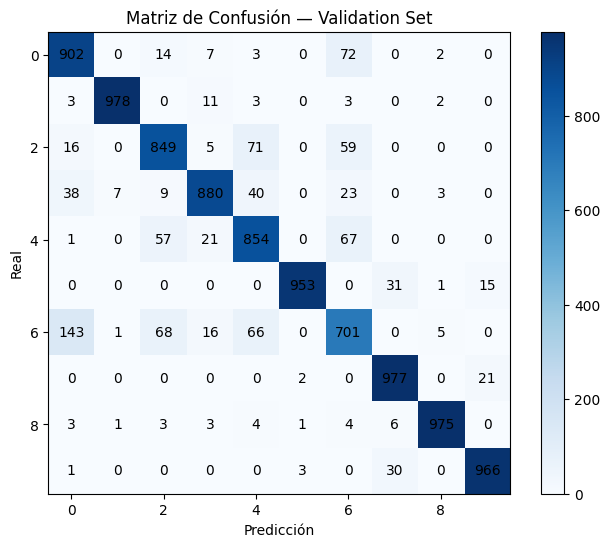

In [47]:
# 6.11)
from sklearn.metrics import confusion_matrix


# 1) Obtener predicciones del validation set
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for X, y in valid_loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        preds = logits.argmax(dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

# 2)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de Confusión — Validation Set")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.colorbar()

# numeritos dentro
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")


plt.savefig("classification_conv_transfer_learning_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

In [48]:
torch.save(model.state_dict(), "clasificador_conv.pth")

## Parte 3) Evaluando la efectividad del pre-entrenamiento

### Parte 3.1) Entrenamiento completo SIN pre-entrenamiento. (*Baseline*)

* encoder → aleatorio

* clasificador → aleatorio

* se entrena TODO

### Parte 3.2) Entrenamiento completo CON encoder pre-entrenado (*Fine-tuning*)

* encoder → preentrenado

* clasificador → aleatorio

* se entrena TODO

### Parte 3.3) Entrenar SOLO el clasificador SIN pre-entrenamiento

* encoder → aleatorio

* clasificador → entrenable

* se entrena el Clasificador

### Parte 3.4) igual que Parte 2

* encoder → pre-entrenado

* clasificador → entrenable

* se entrena el Clasificador

In [54]:
class ClasificadorConv(nn.Module):

    def __init__(
        self,
        encoder: nn.Module,
        num_classes: int = 10,
        freeze_encoder: bool = False,
        hidden_dim: int = 128,
        dropout: float = 0.3
    ):
        super().__init__()

        self.encoder = encoder

        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False

        # inferir dimensión automáticamente
        with torch.no_grad():
            device = next(self.encoder.parameters()).device
            dummy = torch.zeros(1, 1, 28, 28, device=device)
            feat = self.encoder(dummy)
            feat_dim = feat.view(1, -1).shape[1]


        self.clasificador = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, hidden_dim), # capa densa 1 (oculta)
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes) # capa densa 2 (salida)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.clasificador(x)
        return x

In [55]:
checkpoint_path = "autoencoder_conv_10.pth"

In [56]:
# Instanciar un Autoencoder nuevo, y tomar su Encoder
def create_random_encoder(checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    autoencoder = AutoencoderConv(
        n=checkpoint["n"],
        p=checkpoint["p"]
    ).to(device)

    return autoencoder.encoder

In [57]:
def create_pretrained_encoder(checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    autoencoder = AutoencoderConv(
        n=checkpoint["n"],
        p=checkpoint["p"]
    ).to(device)

    autoencoder.load_state_dict(checkpoint["model_state_dict"])

    return autoencoder.encoder

In [58]:
# Experimento 1: Entreno todo desde cero
encoder_random = create_random_encoder(checkpoint_path, device)

model_scratch = ClasificadorConv(
    encoder=encoder_random,
    freeze_encoder=False
).to(device)

In [59]:
# Experimento 2: Fine-tuning
encoder_pretrained = create_pretrained_encoder(checkpoint_path, device)

model_finetune = ClasificadorConv(
    encoder=encoder_pretrained,
    freeze_encoder=False
).to(device)

In [60]:
# Experimento 3: solo clasificador, encoder random congelado
encoder_random_frozen = create_random_encoder(checkpoint_path, device)

model_frozen_random = ClasificadorConv(
    encoder=encoder_random_frozen,
    freeze_encoder=True
).to(device)

In [61]:
# Experimento 4: Encoder preentrenado congelado
# (Transfer Learning puro / Feature Extractor)
encoder_pretrained_frozen = create_pretrained_encoder(checkpoint_path, device)

model_pretrained_frozen = ClasificadorConv(
    encoder=encoder_pretrained_frozen,
    freeze_encoder=True
).to(device)

### Instanciamos los modelos

In [62]:
# # optimizer = torch.optim.Adam(
# #     model.parameters(),
# #     lr=learning_rate,
# #     eps=1e-8,
# #     weight_decay=0,
# #     amsgrad=False
# # )
# def get_optimizer(model, learning_rate=1e-3):
#     params = filter(lambda p: p.requires_grad, model.parameters())
#     return torch.optim.Adam(params, lr=learning_rate)


In [63]:
# FUNCION GENERAL DE ENTRENAMIENTO POR MODELO
def train_model(model, model_name, num_epochs, train_loader, valid_loader, loss_fn):

    print("\n==============================")
    print(f"Entrenando modelo: {model_name}")
    print("==============================")

    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate
    )

    history = {
        "train_loss_inc": [],
        "train_loss": [],
        "valid_loss": [],
        "train_acc_inc": [],
        "train_acc": [],
        "valid_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}\n----------")

        train_loss_inc, train_acc_inc = train_loop(
            train_loader, model, loss_fn, optimizer
        )

        train_loss, train_acc = eval_loop(
            train_loader, model, loss_fn, ds_train_valid="train"
        )

        valid_loss, valid_acc = eval_loop(
            valid_loader, model, loss_fn, ds_train_valid="valid"
        )

        history["train_loss_inc"].append(train_loss_inc)
        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)
        history["train_acc_inc"].append(train_acc_inc)
        history["train_acc"].append(train_acc)
        history["valid_acc"].append(valid_acc)

    print("Done!")
    return history


In [64]:
# ENTRENAR LOS 4
num_epochs = 50   # para testear

results = {}

results["scratch"] = train_model(
    model_scratch, "Scratch", num_epochs,
    train_loader, valid_loader, loss_fn
)

results["fine_tuning"] = train_model(
    model_finetune, "Fine Tuning", num_epochs,
    train_loader, valid_loader, loss_fn
)

results["random_frozen"] = train_model(
    model_frozen_random, "Random Frozen", num_epochs,
    train_loader, valid_loader, loss_fn
)

results["pretrained_frozen"] = train_model(
    model_pretrained_frozen, "Pretrained Frozen", num_epochs,
    train_loader, valid_loader, loss_fn
)



Entrenando modelo: Scratch

Epoch 1
----------
@train_loop batch=     0 avrg_loss =2.305235 sample procesados= 0.166667%
@train_loop batch=    60 avrg_loss =1.093670 sample procesados= 10.166667%
@train_loop batch=   120 avrg_loss =0.886088 sample procesados= 20.166667%
@train_loop batch=   180 avrg_loss =0.778743 sample procesados= 30.166667%
@train_loop batch=   240 avrg_loss =0.712476 sample procesados= 40.166667%
@train_loop batch=   300 avrg_loss =0.665050 sample procesados= 50.166667%
@train_loop batch=   360 avrg_loss =0.631412 sample procesados= 60.166667%
@train_loop batch=   420 avrg_loss =0.603201 sample procesados= 70.166667%
@train_loop batch=   480 avrg_loss =0.579622 sample procesados= 80.166667%
@train_loop batch=   540 avrg_loss =0.562269 sample procesados= 90.166667%
@eval_loop [train] avg_loss = 0.330669 precision = 87.7%
@eval_loop [valid] avg_loss = 0.358046 precision = 86.9%

Epoch 2
----------
@train_loop batch=     0 avrg_loss =0.371387 sample procesados= 0.166

In [66]:
# TABLA COMPARATIVA

rows = []

for name, hist in results.items():
    rows.append({
        "Modelo": name,
        "Train Loss": hist["train_loss"][-1] if len(hist["train_loss"]) else None,
        "Valid Loss": hist["valid_loss"][-1] if len(hist["valid_loss"]) else None,
        "Train Accuracy": hist["train_acc"][-1] if len(hist["train_acc"]) else None,
        "Valid Accuracy": hist["valid_acc"][-1] if len(hist["valid_acc"]) else None,
        "Gap Accuracy (%)": (
            abs(hist["train_acc"][-1] - hist["valid_acc"][-1]) * 100
            if len(hist["train_acc"]) and len(hist["valid_acc"]) else None
        )
    })

df_results = pd.DataFrame(rows)
df_results = df_results.sort_values("Valid Accuracy", ascending=False)

df_results

# =========================
# EXPORTAR A LATEX
# =========================

latex_table = df_results.to_latex(
    index=False,
    float_format="%.4f",
    caption="Resultados de modelos",
    label="tab:resultados"
)

with open("tabla_resultados.tex", "w") as f:
    f.write(latex_table)

In [78]:
df_results

,Modelo,Train Loss,Valid Loss,Train Accuracy,Valid Accuracy,Gap Accuracy (%)
1,fine_tuning,0.017203,0.315448,0.995500,0.9276,6.790000
0,scratch,0.024761,0.306684,0.992233,0.9260,6.623333
3,pretrained_frozen,0.150158,0.291269,0.941967,0.9041,3.786667
2,random_frozen,0.375184,0.412511,0.857500,0.8469,1.060000


In [67]:
latex_table

'\\begin{table}\n\\caption{Resultados de modelos}\n\\label{tab:resultados}\n\\begin{tabular}{lrrrrr}\n\\toprule\nModelo & Train Loss & Valid Loss & Train Accuracy & Valid Accuracy & Gap Accuracy (%) \\\\\n\\midrule\nfine_tuning & 0.0172 & 0.3154 & 0.9955 & 0.9276 & 6.7900 \\\\\nscratch & 0.0248 & 0.3067 & 0.9922 & 0.9260 & 6.6233 \\\\\npretrained_frozen & 0.1502 & 0.2913 & 0.9420 & 0.9041 & 3.7867 \\\\\nrandom_frozen & 0.3752 & 0.4125 & 0.8575 & 0.8469 & 1.0600 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

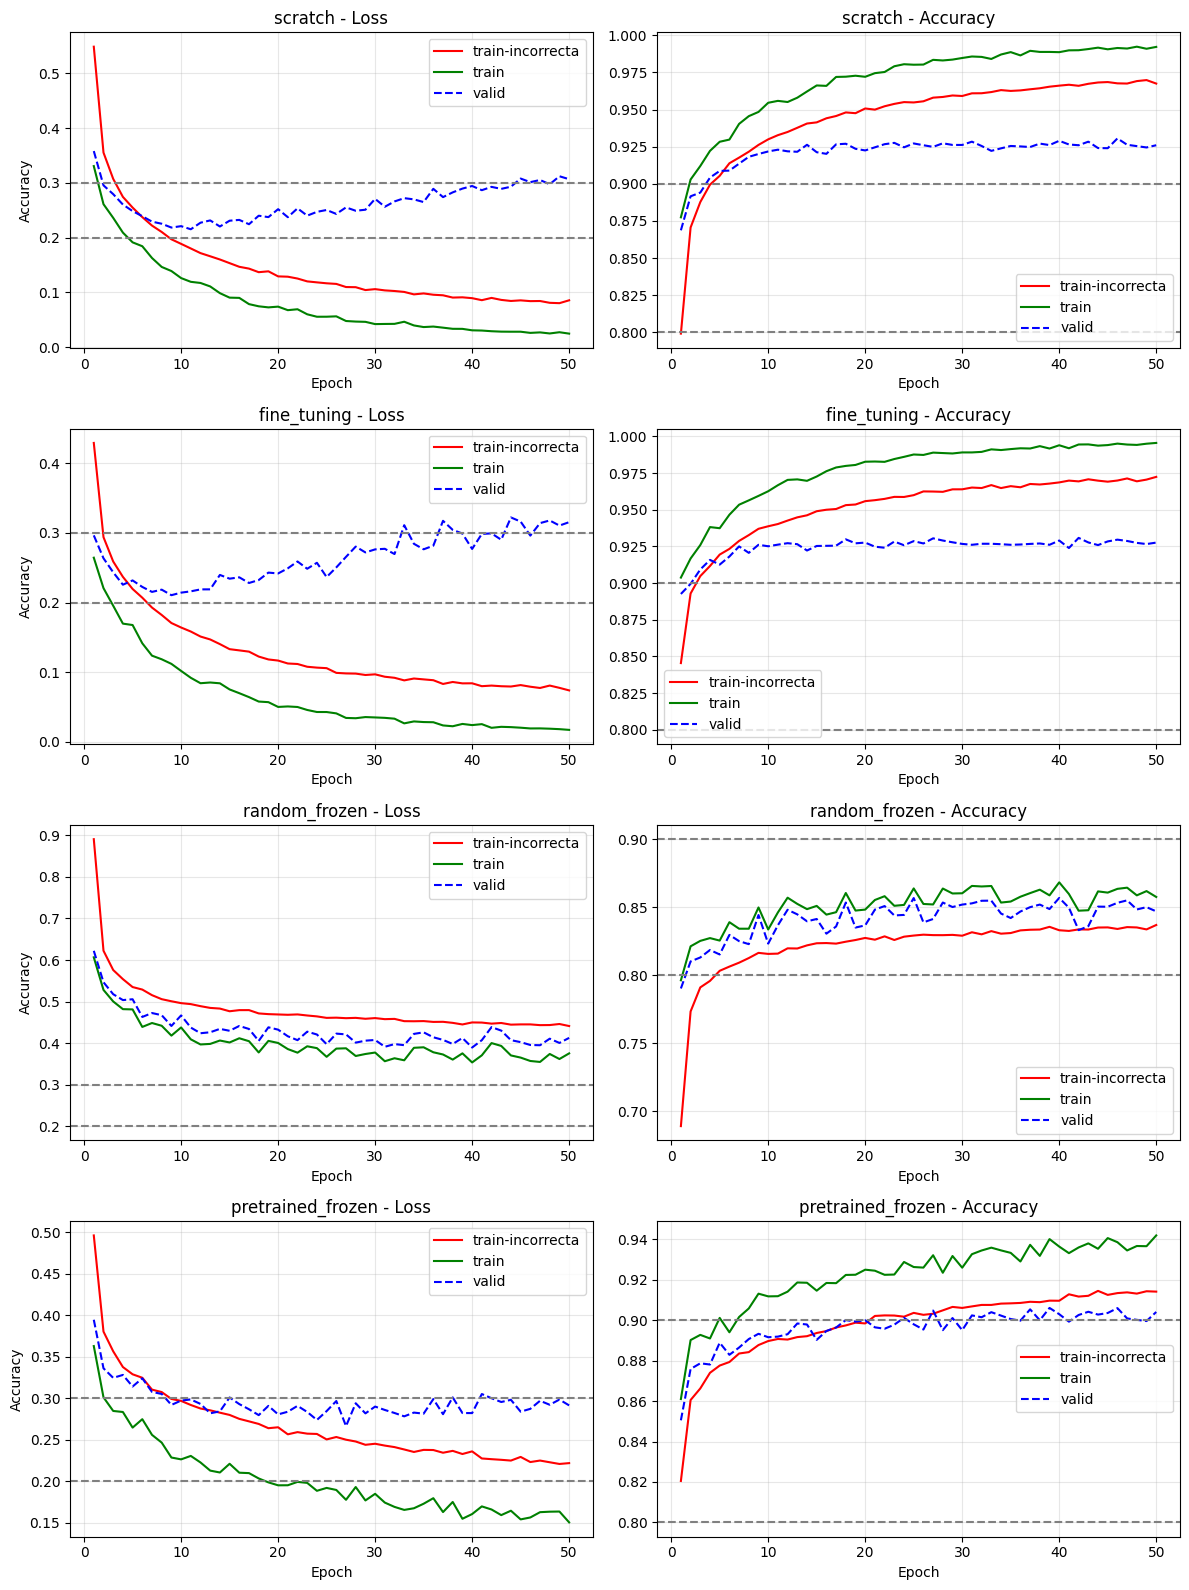

In [68]:
# GRAFICO
n_models = len(results)

fig, axes = plt.subplots(n_models, 2, figsize=(12, 4*n_models))

# cuando hay un solo modelo matplotlib rompe el indexing
if n_models == 1:
    axes = [axes]

for row, (name, hist) in enumerate(results.items()):

    epochs = range(1, len(hist["train_loss"]) + 1)

    # ----- LOSS -----
    axes[row][0].plot(epochs, hist["train_loss_inc"],
                      label="train-incorrecta", linestyle='-', color='red')

    axes[row][0].plot(epochs, hist["train_loss"],
                      label="train", linestyle='-', color='green')

    axes[row][0].plot(epochs, hist["valid_loss"],
                      label="valid", linestyle='--', color='blue')

    # líneas de referencia loss
    axes[row][0].axhline(y=0.3, color='grey', linestyle='--')
    axes[row][0].axhline(y=0.2, color='grey', linestyle='--')

    axes[row][0].set_title(f"{name} - Loss")
    axes[row][0].set_ylabel("Cross Entropy Loss")
    axes[row][0].set_xlabel("Epoch")
    axes[row][0].grid(alpha=0.3)
    axes[row][0].legend()

    # ----- ACCURACY -----
    axes[row][1].plot(epochs, hist["train_acc_inc"],
                      label="train-incorrecta", linestyle='-', color='red')

    axes[row][1].plot(epochs, hist["train_acc"],
                      label="train", linestyle='-', color='green')

    axes[row][1].plot(epochs, hist["valid_acc"],
                      label="valid", linestyle='--', color='blue')

    # líneas de referencia accuracy
    axes[row][1].axhline(y=0.8, color='grey', linestyle='--')
    axes[row][1].axhline(y=0.9, color='grey', linestyle='--')

    axes[row][1].set_title(f"{name} - Accuracy")
    axes[row][0].set_ylabel("Accuracy")
    axes[row][1].set_xlabel("Epoch")
    axes[row][1].grid(alpha=0.3)
    axes[row][1].legend()


plt.tight_layout()
plt.savefig("classification_experiments_loss_acc.png", dpi=300, bbox_inches="tight")
plt.show()

### Confusion Matrix para cada Experimento

In [75]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(
    model,
    data_loader,
    device,
    save_path=None,
    title="Matriz de Confusión (Normalizada)",
    class_names=None
):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)

            logits = model(X)
            preds = logits.argmax(dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # NORMALIZADA POR FILA (clase real)
    cm = confusion_matrix(y_true, y_pred, normalize="true")

    # ===== ORDENAR LABELS POR ÍNDICE =====
    class_names = [labels_names[i] for i in sorted(labels_names.keys())]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap="Blues", vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.colorbar()

    # etiquetas de clase
    if class_names is not None:
        ticks = np.arange(len(class_names))
        plt.xticks(ticks, class_names, rotation=45)
        plt.yticks(ticks, class_names)

    # numeritos (formato porcentaje o decimal)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            plt.text(
                j, i,
                f"{value:.2f}",   # o f"{value*100:.1f}%"
                ha="center",
                va="center",
                color="white" if value > thresh else "black"
            )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.savefig(
            f"classification_experiments_{model.__class__.__name__}_confusion_matrix.png",
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()

    return cm

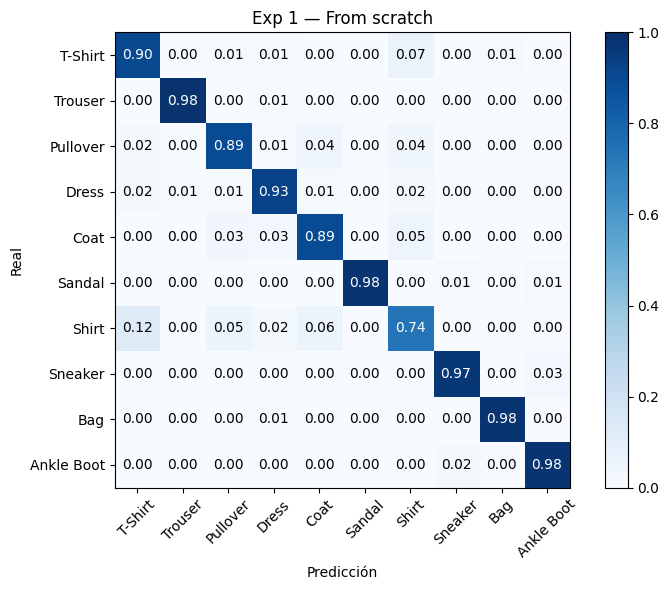

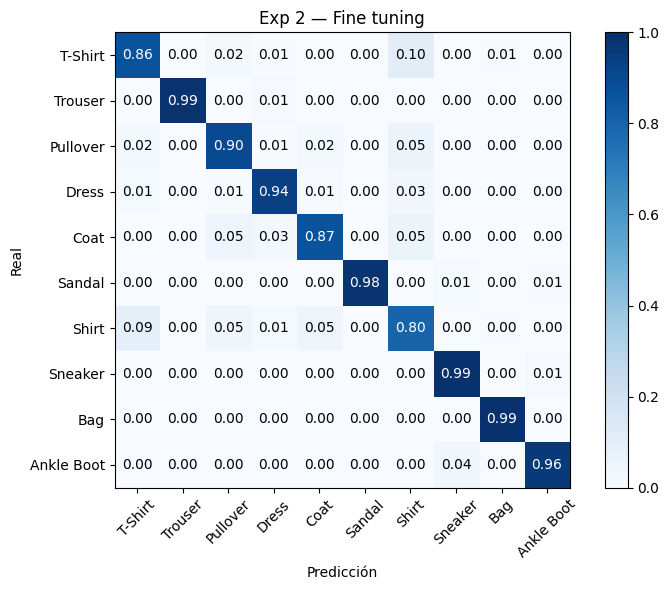

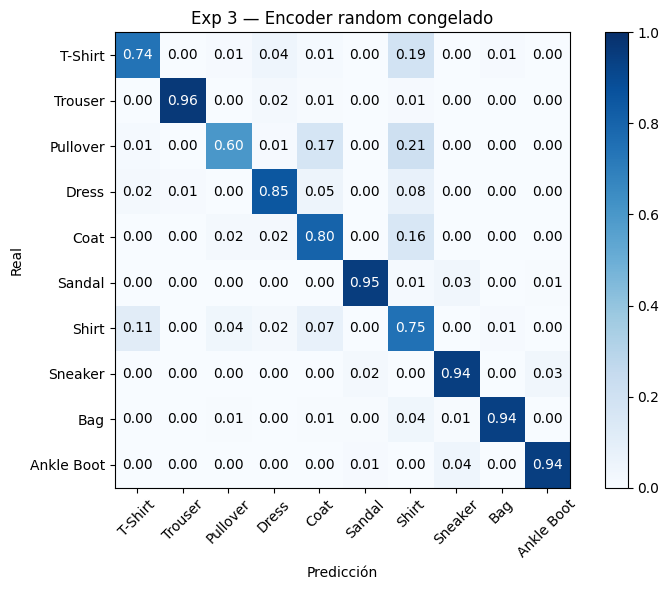

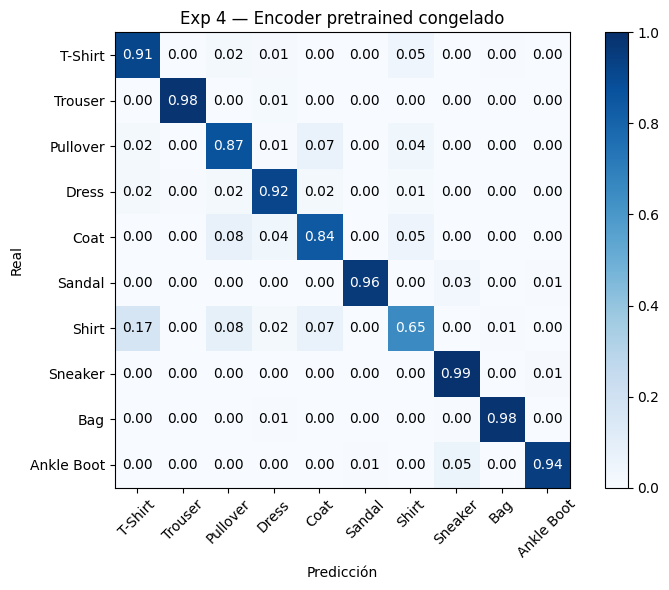

array([[0.913, 0.   , 0.023, 0.01 , 0.003, 0.001, 0.046, 0.   , 0.004,
        0.   ],
       [0.002, 0.978, 0.002, 0.013, 0.003, 0.   , 0.002, 0.   , 0.   ,
        0.   ],
       [0.022, 0.001, 0.866, 0.005, 0.067, 0.   , 0.038, 0.   , 0.001,
        0.   ],
       [0.023, 0.004, 0.017, 0.916, 0.023, 0.   , 0.015, 0.   , 0.002,
        0.   ],
       [0.001, 0.   , 0.076, 0.036, 0.84 , 0.   , 0.047, 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.964, 0.   , 0.031, 0.   ,
        0.005],
       [0.168, 0.003, 0.084, 0.022, 0.067, 0.   , 0.649, 0.   , 0.007,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.989, 0.   ,
        0.011],
       [0.001, 0.   , 0.002, 0.005, 0.002, 0.001, 0.002, 0.004, 0.983,
        0.   ],
       [0.001, 0.   , 0.   , 0.   , 0.   , 0.005, 0.   , 0.051, 0.   ,
        0.943]])

In [76]:
plot_confusion_matrix(
    model_scratch,
    valid_loader,
    device,
    save_path="exp1_confusion.png",
    title="Exp 1 — From scratch"
)

plot_confusion_matrix(
    model_finetune,
    valid_loader,
    device,
    save_path="exp2_confusion.png",
    title="Exp 2 — Fine tuning"
)

plot_confusion_matrix(
    model_frozen_random,
    valid_loader,
    device,
    save_path="exp3_confusion.png",
    title="Exp 3 — Encoder random congelado"
)

plot_confusion_matrix(
    model_pretrained_frozen,
    valid_loader,
    device,
    save_path="exp4_confusion.png",
    title="Exp 4 — Encoder pretrained congelado"
)

## Arquitectura

ver https://pypi.org/project/torchview/


In [71]:
pip install torchview

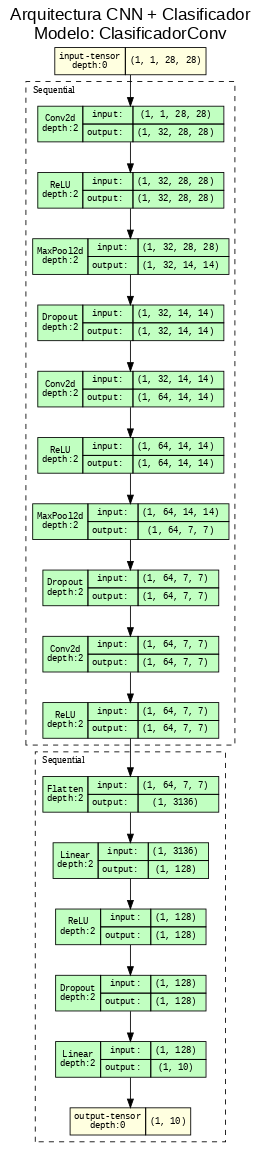

In [77]:
from torchview import draw_graph
from IPython.display import Image #, display
model = model_finetune
model.eval()

model_device = next(model.parameters()).device
dummy_input = torch.zeros(1, 1, 28, 28).to(model_device)

graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    show_shapes=True,   # esto sí existe en todas
    depth=6
)

# ===== AGREGAR TÍTULO GLOBAL =====
graph.visual_graph.attr(
    label=f"Arquitectura CNN + Clasificador\nModelo: {model.__class__.__name__}",
    labelloc="t",     # top
    fontsize="20",
    fontname="Helvetica"
)

# ===== GUARDAR / MOSTRAR =====
path = "arquitectura_model_finetune"
graph.visual_graph.render(path, format="png", cleanup=True)

display(Image(filename=f"{path}.png"))

## Resultados

Desde el punto de vista cuantitativo, los modelos que permiten entrenar el encoder durante la tarea supervisada —entrenamiento desde cero (Exp.1) y fine tuning (Exp.2)— alcanzan el mejor desempeño global. En ambos casos la **Loss en el conjunto de entrenamiento** desciende por debajo de 0.1, mientras que la **Loss en el conjunto de validación** alcanza un mínimo cercano a 0.22 aproximadamente entre las épocas 10 y 20. El **Accuracy de entrenamiento** se aproxima a 1, y el **Accuracy en el conjunto de validación** se estabiliza alrededor de 0.92–0.93.  

Sin embargo, ambos modelos muestran evidencia clara de **sobreajuste** (*overfitting*), ya que pasada la época 20 la Loss en el conjunto de validación comienza a aumentar, mientras que la Loss en el conjunto de entrenamiento continúa disminuyendo.

El modelo con encoder preentrenado congelado (Exp.4) presenta un desempeño intermedio, con Loss de validación en el rango 0.27–0.30 y Accuracy cercano a 0.90. En contraste, el modelo con encoder aleatorio congelado (Exp.3) obtiene el peor rendimiento, con Loss de validación alrededor de 0.4 y Accuracy cercano a 0.85.

En términos de dinámica de entrenamiento, los modelos que entrenan el encoder muestran mayor capacidad de ajuste a la tarea de clasificación, pero también mayor propensión al sobreajuste. Por el contrario, los modelos con encoder congelado presentan curvas de entrenamiento y validación más estables y sin divergencias evidentes en el rango de épocas analizado, aunque con menor desempeño final.  

La ausencia de sobreajuste abre la posibilidad de que estos modelos puedan beneficiarse de un entrenamiento más prolongado. Extender la cantidad de épocas permitiría evaluar si su desempeño continúa mejorando progresivamente o si, por el contrario, ya han alcanzado una etapa de estancamiento en el aprendizaje.

Las matrices de confusión evaluadas sobre el conjunto de validación tras 50 épocas están **normalizadas por clase real**, de modo que cada fila suma 1 y representa la distribución de predicciones condicionada al rótulo verdadero. Esto permite interpretar los valores como probabilidades de clasificación por clase.

Todas las matrices muestran un patrón de error consistente entre configuraciones: la mayor confusión se produce entre las clases *T-Shirt* y *Shirt*, lo cual resulta esperable dada su similitud visual.

Comparativamente, el modelo con fine tuning presenta la mayor concentración de probabilidad sobre la diagonal principal, indicando el mejor desempeño global. Asimismo, dado que los modelos que entrenan el encoder presentan sobreajuste a partir de las 10–20 épocas, es razonable esperar que su desempeño pudiera mejorar si se evaluaran en el punto de mejor validación mediante *early stopping*.


## Discusión y conclusiones

El autoencoder convolucional aprende representaciones comprimidas que preservan la estructura visual de los artículos del dataset Fashion-MNIST. Al reutilizar el encoder como extractor de características, el clasificador converge más rápidamente.

Esto confirma que el aprendizaje no supervisado permite *capturar regularidades estructurales de los datos* que resultan útiles para tareas supervisadas posteriores. *Sin embargo, el congelamiento total del encoder limita su capacidad de adaptación a la tarea de clasificación*, lo que explica el menor desempeño observado respecto de los modelos que permiten ajustar toda la red.

Los resultados también muestran que el preentrenamiento no garantiza automáticamente el mejor rendimiento. Su efectividad depende del grado de alineación entre la tarea de preentrenamiento y la tarea final. En este caso, el autoencoder fue optimizado para reconstrucción de imágenes, lo que favorece la preservación de información visual general, pero no necesariamente la separabilidad entre clases.

En conjunto, los experimentos indican que el preentrenamiento proporciona representaciones informativas y estables, pero *la adaptación supervisada del encoder resulta fundamental* cuando el objetivo es maximizar la capacidad discriminativa del modelo.

Estos hallazgos son consistentes con el enfoque dominante en aprendizaje profundo moderno, donde primero se aprenden representaciones generales de los datos y luego se especializan mediante ajuste supervisado para tareas específicas.

El *transfer learning* resulta especialmente útil en datasets pequeños, donde reutilizar representaciones aprendidas mejora la estabilidad y acelera la convergencia. Entrenar desde cero suele recomendarse solo con grandes volúmenes de datos etiquetados, del orden de miles de ejemplos por clase (Lakshmanan et al., 2021, p. 60).

Este principio es ampliamente explotado en modelos modernos de visión artificial y procesamiento del lenguaje, donde se entrena primero una representación general y luego se la especializa para tareas concretas.

En síntesis, el preentrenamiento no garantiza automáticamente el mejor modelo, pero puede constituir una estrategia valiosa dentro de un enfoque más amplio de diseño y entrenamiento de redes neuronales profundas. Su utilidad práctica depende del equilibrio entre la calidad de las representaciones aprendidas previamente y la necesidad de adaptarlas a la tarea específica de interés.

**Referencia**

Lakshmanan, V., Görner, M., & Gillard, R. (2021). *Practical Machine Learning for Computer Vision*. O'Reilly Media.